# Import Library

In [112]:
import statsmodels.api as sm
import ccxt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import requests
from statsmodels.tsa.stattools import coint

# Fetch Data

## BTC/USDT

In [53]:
binance = ccxt.binance()
btc_usdt_ohlcv = binance.fetch_ohlcv('BTC/USDT', '1h')
btc_usdt_df = pd.DataFrame(btc_usdt_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
btc_usdt_df['timestamp'] = pd.to_datetime(btc_usdt_df['timestamp'], unit='ms') 
btc_usdt_df.set_index('timestamp', inplace=True)
btc_usdt_df.head()

,open,high,low,close,volume
timestamp,,,,,
2023-11-20 23:00:00,37425.78,37605.76,37425.78,37448.78,901.20393
2023-11-21 00:00:00,37448.79,37516.48,37304.72,37394.17,807.25113
2023-11-21 01:00:00,37394.16,37630.60,37350.13,37600.61,931.86557
2023-11-21 02:00:00,37600.61,37649.44,37419.57,37452.34,1203.93489
2023-11-21 03:00:00,37452.33,37555.99,37399.99,37464.86,827.17777


## BTC/THB

In [55]:
btc_thb_url = "https://api.bitkub.com/tradingview/history?symbol={symbol}&resolution={timeframe}&from=1700488800&to=1702285200".format(symbol='BTC_THB', timeframe="60")
btc_thb_response = requests.get(btc_thb_url)
btc_thb_data = btc_thb_response.json()
del btc_thb_data["s"]
btc_thb_df = pd.DataFrame(btc_thb_data).rename(columns={
    "c": "close",
    "h": "high",
    "l": "low",
    "o": "open",
    "t": "timestamp",
    "v": "volume"
})
btc_thb_df['timestamp'] = pd.to_datetime(btc_thb_df['timestamp'], unit='s') 
btc_thb_df.set_index('timestamp', inplace=True)
btc_thb_df.head()

,close,high,low,open,volume
timestamp,,,,,
2023-11-20 14:00:00,1315554.76,1316350.00,1290000.00,1304970.04,5.381723
2023-11-20 15:00:00,1317000.00,1317721.23,1309255.21,1314248.00,6.230844
2023-11-20 16:00:00,1312230.00,1325000.00,1312230.00,1317120.00,12.470449
2023-11-20 17:00:00,1311812.88,1312655.95,1311000.00,1312655.95,0.147346
2023-11-20 19:00:00,1322000.00,1322000.00,1317950.00,1317950.00,0.137814


## USDT/THB

In [63]:
usdt_thb_url = "https://api.bitkub.com/tradingview/history?symbol={symbol}&resolution={timeframe}&from=1700488800&to=1702285200".format(symbol='USDT_THB', timeframe="60")
usdt_thb_response = requests.get(usdt_thb_url)
usdt_thb_data = usdt_thb_response.json()
del usdt_thb_data["s"]
usdt_thb_df = pd.DataFrame(usdt_thb_data).rename(columns={
    "c": "close_forex",
    "h": "high_forex",
    "l": "low_forex",
    "o": "open_forex",
    "t": "timestamp",
    "v": "volume_forex",
})
usdt_thb_df['timestamp'] = pd.to_datetime(usdt_thb_df['timestamp'], unit='s') 
usdt_thb_df.set_index('timestamp', inplace=True)
usdt_thb_df.head()

,close_forex,high_forex,low_forex,open_forex,volume_forex
timestamp,,,,,
2023-11-20 14:00:00,35.15,35.19,35.13,35.16,736008.43
2023-11-20 15:00:00,35.17,35.20,35.14,35.14,697665.76
2023-11-20 16:00:00,35.24,35.24,35.15,35.16,431474.85
2023-11-20 17:00:00,35.23,35.24,35.23,35.24,68097.64
2023-11-20 19:00:00,35.19,35.24,35.19,35.24,43111.80


# Processing Data

In [97]:
merge_df = pd.merge(btc_thb_df, btc_usdt_df, on='timestamp', suffixes=('_thb', '_usdt'))
merge_df = pd.merge(merge_df, usdt_thb_df, on='timestamp', suffixes=('', '_forex'))

merge_df["convert_close_usdt"] = merge_df["close_usdt"] * merge_df["close_forex"]
merge_df["usdt_thb_diff"] = merge_df["convert_close_usdt"]-merge_df["close_thb"]

In [98]:
merge_df[['close_usdt','close_thb',"close_forex","convert_close_usdt","usdt_thb_diff"]].head()

,close_usdt,close_thb,close_forex,convert_close_usdt,usdt_thb_diff
timestamp,,,,,
2023-11-20 23:00:00,37448.78,1321884.88,35.28,1.321193e+06,-691.9216
2023-11-21 00:00:00,37394.17,1314982.53,35.14,1.314031e+06,-951.3962
2023-11-21 01:00:00,37600.61,1320960.46,35.13,1.320909e+06,-51.0307
2023-11-21 02:00:00,37452.34,1318999.09,35.20,1.318322e+06,-676.7220
2023-11-21 03:00:00,37464.86,1317736.88,35.16,1.317264e+06,-472.4024


In [93]:
# Perform cointegration test
result = coint(merge_df['close_thb'], merge_df['convert_close_usdt'])

# Extract test statistic and p-value
test_statistic, p_value, _ = result

# Print results
print('Cointegration Test:')
print('Test Statistic:', test_statistic)
print('p-value:', p_value)
print('Is Cointegrated:', p_value <= 0.05)

Cointegration Test:
Test Statistic: -16.849891274010123
p-value: 8.181549246660043e-29
Is Cointegrated: True


# Plot Data

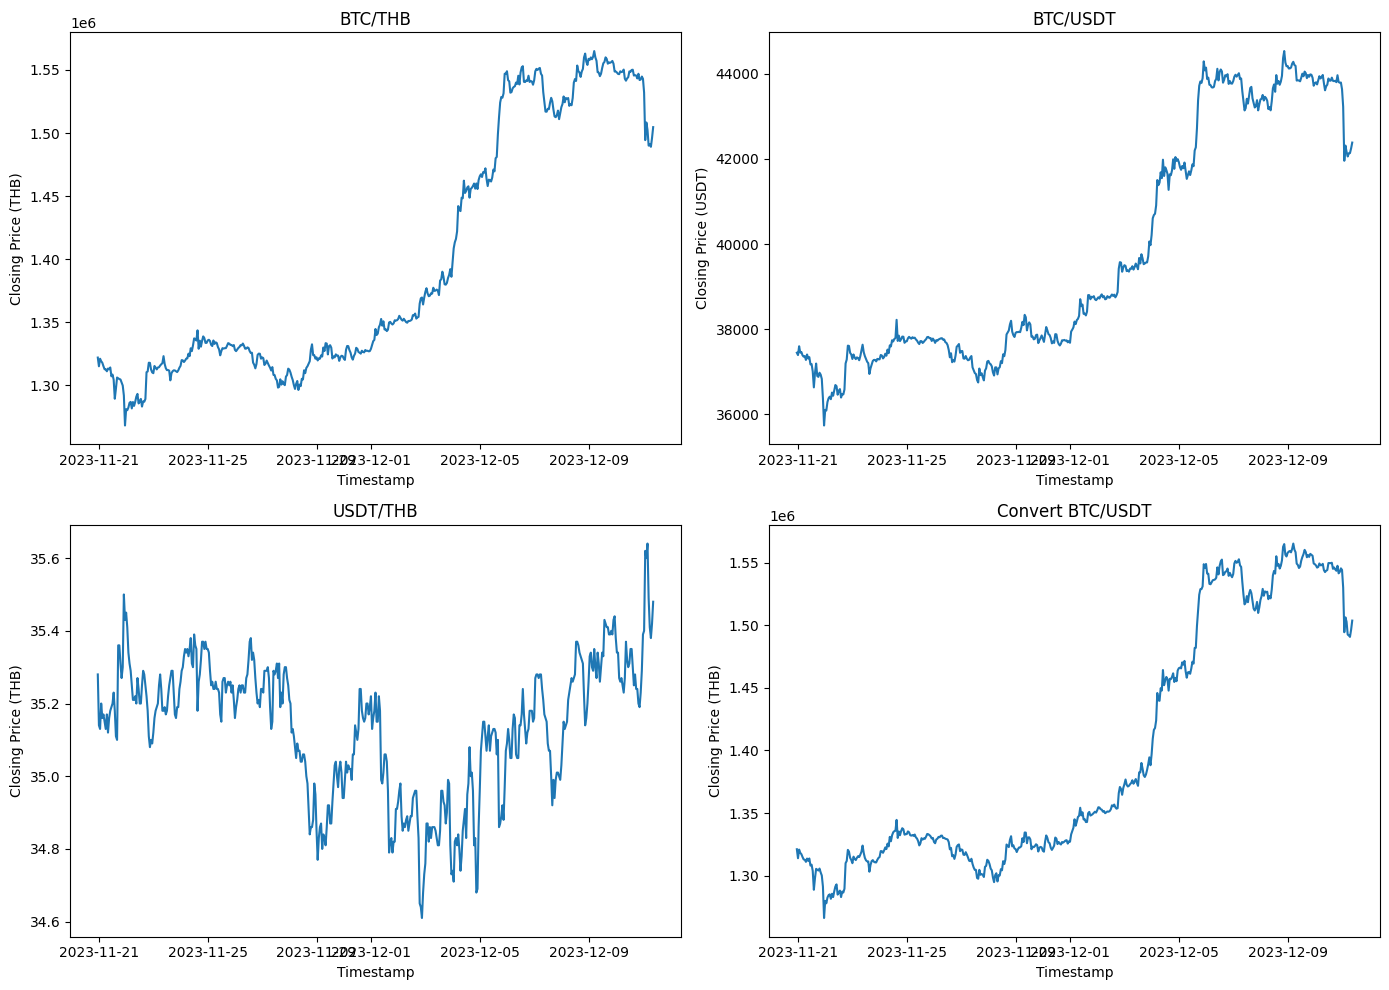

In [89]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

axes[0, 0].plot(merge_df["close_thb"])
axes[0, 0].set_title("BTC/THB")
axes[0, 0].set_xlabel("Timestamp")
axes[0, 0].set_ylabel("Closing Price (THB)")

axes[0, 1].plot(merge_df["close_usdt"])
axes[0, 1].set_title("BTC/USDT")
axes[0, 1].set_xlabel("Timestamp")
axes[0, 1].set_ylabel("Closing Price (USDT)")

axes[1,0].plot(merge_df["close_forex"])
axes[1,0].set_title("USDT/THB")
axes[1,0].set_xlabel("Timestamp")
axes[1,0].set_ylabel("Closing Price (THB)")

axes[1,1].plot(merge_df["convert_close_usdt"])
axes[1,1].set_title("Convert BTC/USDT")
axes[1,1].set_xlabel("Timestamp")
axes[1,1].set_ylabel("Closing Price (THB)")

plt.tight_layout()
plt.show()

In [118]:
close_thb = sm.add_constant(merge_df['close_thb'].to_list())
convert_close_usdt = merge_df['convert_close_usdt'].to_list()
results = sm.OLS(convert_close_usdt, close_thb).fit()
beta= results.params[1]

print("beta value: ",beta)

beta value:  1.0001176878843434


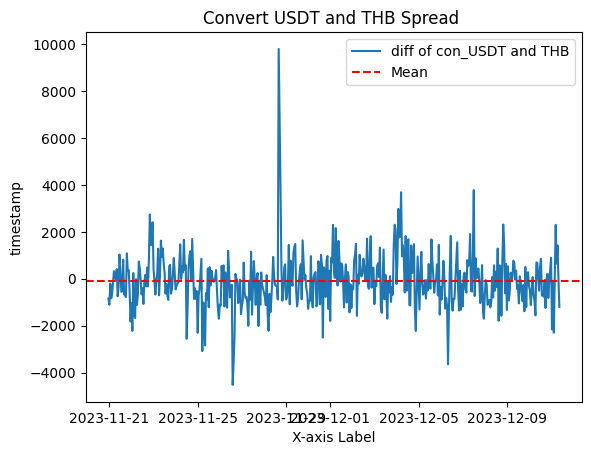

In [129]:
merge_df["spread"] = merge_df['convert_close_usdt'] - beta* merge_df['close_thb']
spread_mean = merge_df["spread"].mean()


plt.plot(merge_df["spread"], label='diff of con_USDT and THB')
plt.axhline(spread_mean, color='red', linestyle='--', label='Mean')

plt.xlabel('X-axis Label')
plt.ylabel('timestamp')
plt.title('Convert USDT and THB Spread ')

plt.legend()
plt.show()